In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn
from sklearn.naive_bayes import GaussianNB
%matplotlib inline

In [2]:
df = pd.read_csv("../data/train/training_data.csv")

In [3]:
df

,tweet_id,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,12238,12549,3,0,3,0,1,Kim K is alright but honestly so many niggas b...
1,11389,11681,9,3,6,0,1,I'm so mother fucken sexy. I have no time to b...
2,14445,14791,3,0,3,0,1,"RT @Booskerz: ""@DailySexSupply: Girls that fuc..."
3,21900,22367,3,2,1,0,0,Think it's okay to take my property and break ...
4,7795,8015,3,0,3,0,1,"Apologizing in advance for my actions, I'm the..."
5,20770,21219,3,0,3,0,1,"She used to fuck wit A$AP, Too Shortsaid he kn..."
6,5922,6091,3,1,0,2,2,@elise_palmer sounds like gypos to me - they u...
7,13962,14302,3,0,3,0,1,Quit blowing up my feed bitches.
8,24349,24854,3,1,2,0,1,"please tell this bitch I'm subbin her, ik one ..."
9,24256,24760,3,0,3,0,1,never lie \nnever cry\nnever die\nwe gone die\...


In [4]:
df.describe()


,tweet_id,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,19746.000000,19746.000000,19746.000000,19746.000000,19746.000000,19746.000000,19746.000000
mean,12381.339107,12671.394409,3.238681,0.281677,2.404993,0.552011,1.110858
std,7141.148460,7286.119207,0.872648,0.636260,1.398517,1.110029,0.464726
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6196.000000,6373.000000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12399.000000,12711.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18526.750000,18935.750000,3.000000,0.000000,3.000000,0.000000,1.000000
max,24782.000000,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [5]:
df.columns

Index(['tweet_id', 'Unnamed: 0', 'count', 'hate_speech', 'offensive_language',
       'neither', 'class', 'tweet'],
      dtype='object')

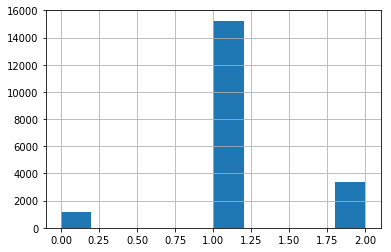

In [6]:
df['class'].hist()

In [7]:
tweets=df.tweet

In [8]:
#Feature generation

In [9]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )


In [10]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()


In [11]:
# get unigram counts for data
def get_unigrams_processed():
    uni = set()
    tweets = df[['tweet']]
    for row_index, row in tweets.iterrows():
        s = tknzr.tokenize(row['tweet'])
        for word in s:
            uni.add(word)    
    return uni

vocabulary_unigrams = get_unigrams_processed()






In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/Users/pratyusha/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [14]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)


In [15]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [16]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [17]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [18]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [ ]:
feats = get_feature_array(tweets)

In [ ]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [ ]:
M.shape

(19746, 9370)

In [ ]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [ ]:
#Running the model
#The best model was selected using a GridSearch with 5-fold CV.

In [ ]:
X = pd.DataFrame(M)
y = df['class'].astype(int)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
pipeLR = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [ ]:
pipeSVM = Pipeline(
        [('select', SelectFromModel(SVC(class_weight='balanced',
                                                   C=0.01))),
        ('model', SVC(class_weight='balanced'))])

In [ ]:
pipeNB = Pipeline(
        [('select', SelectFromModel(GaussianNB())),
        ('model', GaussianNB())])

In [ ]:
whichModel = 'SVM'

In [ ]:
param_grid = [{}] # Optionally add parameters here

In [ ]:
if whichModel == 'LR':
    grid_search = GridSearchCV(pipeLR, 
                               param_grid,
                               cv=StratifiedKFold(n_splits=5, 
                                                  random_state=42).split(X_train, y_train), 
                               verbose=2)
elif whichModel == 'SVM':
    grid_search = GridSearchCV(pipeSVM, 
                               param_grid,
                               cv=StratifiedKFold(n_splits=5, 
                                                  random_state=42).split(X_train, y_train), 
                               verbose=2)
elif whichModel == 'NB':
    grid_search = GridSearchCV(pipeNB, 
                               param_grid,
                               cv=StratifiedKFold(n_splits=5, 
                                                  random_state=42).split(X_train, y_train), 
                               verbose=2)

In [ ]:
grid_search

GridSearchCV(cv=<generator object _BaseKFold.split at 0x1a259755c8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('select', SelectFromModel(estimator=SVC(C=0.01, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
        max_...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None, param_grid=[{}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [ ]:
#model = grid_search.fit(X_train, y_train)

In [ ]:
model = SVC().fit(X_train,y_train)

In [ ]:
y_preds = model.predict(X_test)

In [ ]:
#Evaluating the results

In [ ]:
report = classification_report( y_test, y_preds )

In [ ]:
#Note: Results in paper are from best model retrained on the entire 
#dataset (see the other notebook). Here the results are reported 
#after using cross-validation and only for the held-out set.

In [ ]:

print(report)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

In [ ]:
#True distribution
y.hist()

In [ ]:
pd.Series(y_preds).hist()